# ロボットビジョン課題 1 「画像処理の基礎」

---
<div style="text-align:right;">
<p style="display:inline-block; text-align:left; font-size:20px; line-height:140%;">
<!--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-->
【学生番号】21Cxxxxxx <br />
【氏　　名】千葉工 名無し
<!--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-->
</p>
</div>

---

## 目次

* 【重要】提出に関して
* 課題 1-1）「（疑似）現像処理」
* 課題 1-1）解答用紙
* 課題 1-2）「パノラマ画像合成」
* 課題 1-2）解答用紙
---


## 【重要】提出に関して
  1. 締め切り：<font color="red" style="font-weight:bolder;">2023年12月10日（日）23:55</font>
      * レポート提出は単位取得のための必須要件なので注意すること
      * 締め切り内の再提出は何度でも可能
      <br>
      <br>
  1. 提出形式：
      * 形式：このJupyter notebook を <font color="red" style="font-weight:bolder;">HTML</font> 化したものを提出すること（拡張子は「.html」）
      * ファイル名は「<font color="red" style="font-weight:bolder;">学生番号\_名前\_課題1.html</font>」とすること（例：21Cxxxx_千葉工名無し_課題1.html）
      * 提出の際には<font color="red" style="font-weight:bolder;">上記の学生番号と氏名も編集して</font>提出すること
      <br>
      <br>
  1. 提出先：[manaba](https://cit.manaba.jp/ct/course_874453_report_927915)
      <br>
      <br>
  1. 注意事項：
      * 課題に用いる画像を自身で準備した場合は著作権・肖像権的に問題のない，公序良俗に反しないものを用いること
      * 提出されたレポートは<font color="red" style="font-weight:bolder;">相互の学習のため公開する可能性があり</font>ますので，第三者に閲覧された際に問題のない画像を用いること．

---
## 【下準備】必要なライブラリのインポート
  1. 上記の「Kernel」→「Restart Run All」を実行

In [3]:
# 外部関数を変更した時のためにキャッシュを参考にしない
%reload_ext autoreload
%autoreload 2

import sys
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt 

#---------------------------------------
# 今までの講義で使った関数が入ったスクリプト
#---------------------------------------
from my_script import *

---
## 課題 1-1）課題「（疑似）現像処理」
  [提供するPGMデータセット](https://www.rsa.it-chiba.ac.jp/lecture/dataset/rawdata/)の中から一つを選択し，自身で作成したプログラムで現像してください．ただし，以下の手順を踏み，それぞれの処理について各処理後の画像を示し，それぞれに施した処理の意図と結果に関する考察を述べること．

### 課題の目的
* ここまでの講義で扱ってきた画像処理の理論を理解しているかの確認
* ここまでの講義で扱ってきたサンプルコードを理解し，必要な関数を用いて上記理論を実装できるかの確認

-----
### 変数の定義
  * ここで適宜，必要なライブラリの追加，変数の定義などを行う

In [4]:
# デモザイキング済みの画像
demosaiced_data = None

---
### PGM ファイルのヘッダ部分のパース

In [5]:
def parse_pgm(fd):
    
    # 16bit pgm（バイナリ）のフォーマット例
    # P5             // P1-P6 改行(\x0A)
    # # comments
    # 4284 2844      // width スペース(\x20) height 改行(\x0A)
    # 65535          //　階調数（2^bit数-1） 改行(\x0A)
    # RGRGRGRG....
    # GBGBGBGB....   // (各色16bitずつ)

    w = 0
    h = 0
    lim = 0
    lines = 0
    count = 0
    wFlag = True
    val = np.array([])

    while True: # 改行コード（0x0A）, スペース（0x20）
        ch = fd.read(1)
        if ch==b'\x23':
            while True:
                ch = fd.read(1)
                if ch==b'\x0A':
                    break
            continue
        elif lines==1:    # 画像の縦横サイズを取得
            if ch==b'\x20' or ch==b'\x0A':
                for i in range(count):
                    if wFlag:
                        w += val[i] * pow(10, count-i-1)
                    else:
                        h += val[i] * pow(10, count-i-1)
                wFlag = False
                val = np.array([])
                count = 0
            else:
                num = int(ch)
                val = np.append(val, num)
                count = count + 1
        elif lines==2:  # センサビット深度の取得
            if ch==b'\x20' or ch==b'\x0A':
                for i in range(count):
                    lim += val[i] * pow(10, count-i-1)
            else:
                num = int(ch)
                val = np.append(val, num)
                count = count + 1
        if ch==b'\x0A':
            lines = lines + 1
        if lines>=3:
            break

    print("(w, h, lim) = ({}, {}, {})".format(w, h, lim))
    
    w = int(w)
    h = int(h)
    lim = int(lim)
    
    return w, h, lim

### デモザイキング関数
  * ひな型として講義で紹介した疑似的なデモザイキング関数を実装
  * 独自で実装を変更してよい

In [6]:
def my_demosaicing(img_path):
    
    # バイナリモードでオープン
    fd = open(img_path, 'rb')
    
    w, h, lim = parse_pgm(fd)
    
    # 階調が255（8ビット）よりも大きい場合は，Big endian で 16 bit ずつ読み込み
    # [エンディアンの参考] https://qiita.com/mski_iksm/items/bb0aa375c952c2d7b91a
    if lim > 255:
        #data = np.fromfile(fd, dtype=np.dtype('>u2'))
        data = np.fromfile(fd, dtype=np.dtype('>H'))
    else:
        data = np.fromfile(fd, dtype=np.dtype('>u1'))
    data = data.astype(float);

    #----------------------------------
    # 以下を独自の実装に変更
    #----------------------------------
    img = np.zeros((h,w,3), dtype=float)
    for v in range(h-1):
        for u in range(w-1):
            i = v * w + u
            if u%2==0 and v%2==0:
                r = data[i]
                g1 = data[i+1]
                g2 = data[i+w]
                b = data[i+w+1]
            elif u%2==1 and v%2==0:
                r = data[i+1]
                g1 = data[i]
                g2 = data[i+w+1]
                b = data[i+w]
            elif u%2==0 and v%2==1:
                r = data[i+w]
                g1 = data[i+w+1]
                g2 = data[i]
                b = data[i+1]
            elif u%2==1 and v%2==1:
                r = data[i+w+1]
                g1 = data[i+w]
                g2 = data[i+1]
                b = data[i]
            img[v,u,0] = r
            img[v,u,1] = (g1+g2)/2.0
            img[v,u,2] = b
    fd.close();
    
    return img, w, h, lim

---
##  課題 1-1）解答用紙

### 1）PGMファイルの読み込みとデモザイキング処理

<font style="font-weight:bolder;">【注意】RAWファイルの解像度が大きいため環境によっては処理に時間がかかることがあります</font>

　→　<font color="red" style="font-weight:bolder;">処理が重いので処理を繰り返すときは次以降のセルから始めると良い</font>

In [7]:
#--------------------------------------------
# ここを選択したPGMファイルに変更すること
#--------------------------------------------
img_path = "data/img13.pgm".replace('/', os.sep) # ファイル名

In [8]:
# デモザイキングの処理を変更する場合は，上記の my_demosaicing() を改変すること
if demosaiced_data is None:
    demosaiced_data, w, h, lim = my_demosaicing(img_path)

(w, h, lim) = (4608.0, 3072.0, 65535.0)


### matplotib での表示

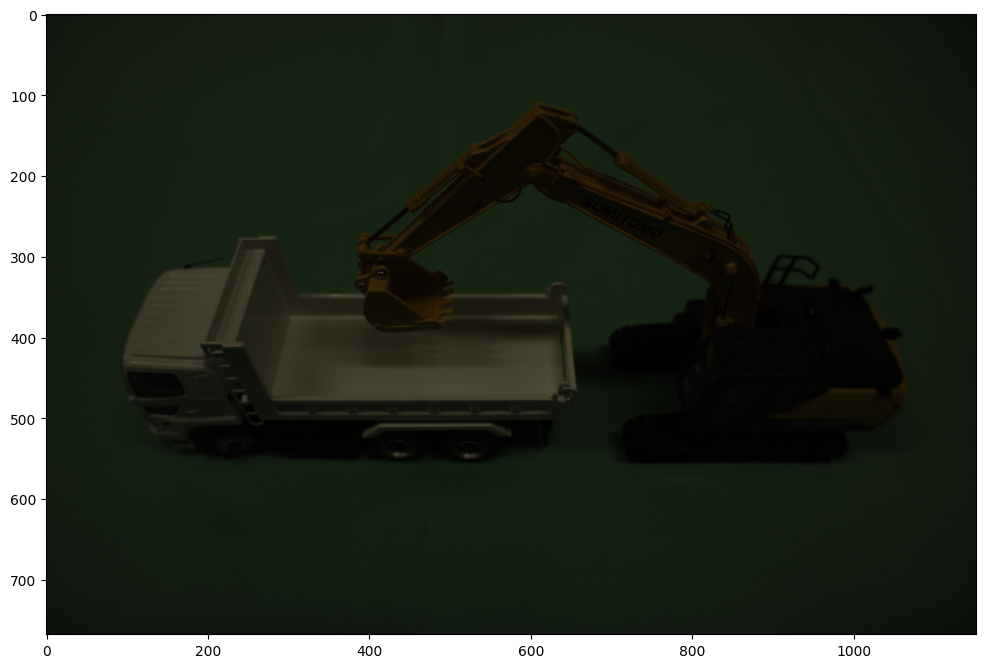

In [9]:
# ここから 8bit 画像（確認用）に変換
R = 255.0 / lim # センサビット数 -> 8bit への等倍変換
demosaiced_data *= R
demosaiced_data = demosaiced_data.astype(np.uint8);

img = cv2.resize(demosaiced_data, (int(w/4), int(h/4)));   # 適当な大きさにリサイズ（ここでは縦横 1/6 に縮小）

plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.show()

----
### 2）画像変換：××の処理（例：コントラスト補正，ガンマ補正，色調補正など）
#### 本処理の狙い
  * 本処理は原画像における暗く、色彩が不明確であるという問題に対し、色調補正によって修正することを目的としている．
  * そのため，■■という特徴を持ったガンマ補正処理とコントラスト補正処理を適用する．

### ガンマ補正

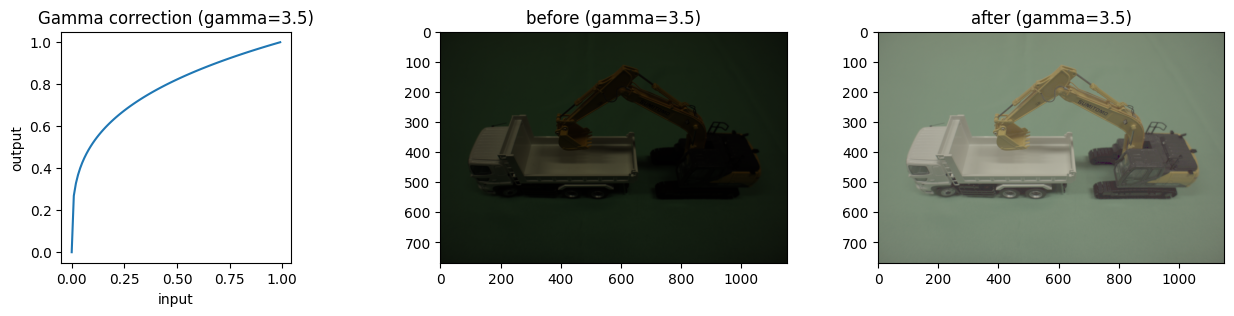

In [13]:
# ガンマ補正関数
# gamma：γ値
def gamma_function(x, params):
    gamma = params
    return x ** (1/gamma)

# トーンカーブ・原画像・補正後画像の表示
def display_gamma_correction(corrected_img, gamma):
    # ここからトーンカーブの描画
    plt.figure(figsize=(16, 3))

    # トーンカーブの作成と描画
    ax = plt.subplot(1, 3, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    x = np.arange(0.0, 1.0, 0.01)    # [0,1] の範囲で 0.01 刻みで入力配列作成
    y = gamma_function(x, gamma)  # 上記に対する出力配列の計算
    plt.plot(x, y)
    plt.title('Gamma correction (gamma={})'.format(gamma))

    # オリジナル画像の描画
    plt.subplot(1, 3, 2)
    plt.imshow(img, vmin = 0, vmax = 255)
    plt.title('before (gamma={})'.format(gamma))

    # ガンマ補正結果の表示
    plt.subplot(1, 3, 3)
    plt.imshow(corrected_img, vmin = 0, vmax = 255)
    plt.title('after (gamma={})'.format(gamma))

    plt.show

gamma = 3.5
gammaprocessed_img = tone_correction(img, gamma_function, gamma) # ガンマ補正の実行
display_gamma_correction(gammaprocessed_img, gamma)

### コントラスト補正

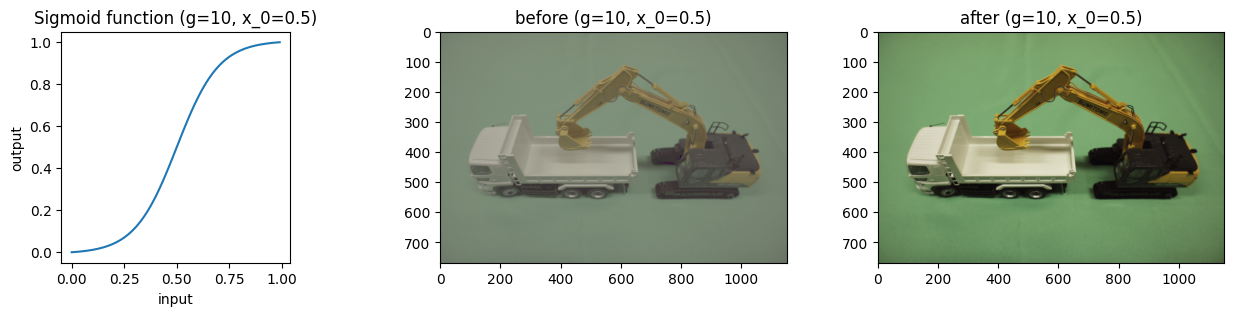

In [14]:
# 階調補正の実行関数
def tone_correction(input, func, params=None):
    # コントラスト補正の実行（速度は度外視）
    output = np.array([(255 * func(a / 255.0, params)).astype('uint8') for a in input]) 
    return output

# シグモイド関数
# gain: 出力のゲイン
# x0: 出力が0.5になる入力の値 [0,1]
def vanilla_sigmoid(x, gain, x0):
    return 1.0 / (1.0 + np.exp((x0 - x) * gain))

# x=0 -> y=0, x=1 -> y=1 となるようにスケーリングしたシグモイド関数
def scaled_sigmoid(x, params):
    gain = params[0]
    x0   = params[1]
    min = vanilla_sigmoid(0.0, gain, x0)
    max = vanilla_sigmoid(1.0, gain, x0)
    s = vanilla_sigmoid(x, gain, x0)
    return (s - min) / (max - min)

# トーンカーブ・原画像・補正後画像の表示
def display_contrast_correction(corrected_img, gain, x0):
    # ここからシグモイド曲線によるコントラスト補正のトーンカーブの描画
    plt.figure(figsize=(16, 3))

    # トーンカーブの作成と描画
    ax = plt.subplot(1, 3, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    x = np.arange(0.0, 1.0, 0.01)      # [0,1] の範囲で 0.01 刻みで入力配列作成
    y = scaled_sigmoid(x, (gain, x0))  # 上記に対する出力配列の計算
    plt.plot(x, y)
    plt.title('Sigmoid function (g={}, x_0={})'.format(gain, x0))

    # オリジナル画像の描画
    plt.subplot(1, 3, 2)
    plt.imshow(gammaprocessed_img, vmin = 0, vmax = 255)
    plt.title('before (g={}, x_0={})'.format(gain, x0))

    # コントラスト補正結果の表示
    plt.subplot(1, 3, 3)
    plt.imshow(corrected_img, vmin = 0, vmax = 255)
    plt.title('after (g={}, x_0={})'.format(gain, x0))

    plt.show()

# 出力結果１
gain = 10
x0   = 0.5
corrected_img = tone_correction(gammaprocessed_img, scaled_sigmoid, (gain, x0)) # コントラスト補正の実行
display_contrast_correction(corrected_img, gain, x0)

# 出力結果２
#gain = 50
#x0   = 0.5
#corrected_img = tone_correction(gammaprocessed_img, scaled_sigmoid, (gain, x0)) # コントラスト補正の実行
#display_contrast_correction(corrected_img, gain, x0)

### 画像の統計量（ヒストグラム）

Text(0.5, 1.0, '1-2 final image')

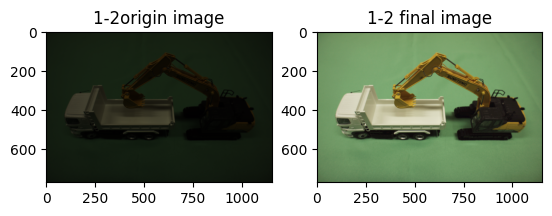

In [15]:
# オリジナル画像の描画
plt.subplot(121)
plt.imshow(img, vmin = 0, vmax = 255)
plt.title("1-2origin image")


# コントラスト補正+ガンマ補正結果の表示
plt.subplot(122)
plt.imshow(corrected_img, vmin = 0, vmax = 255)
plt.title("1-2 final image")


### RGB

<Figure size 1600x1600 with 0 Axes>

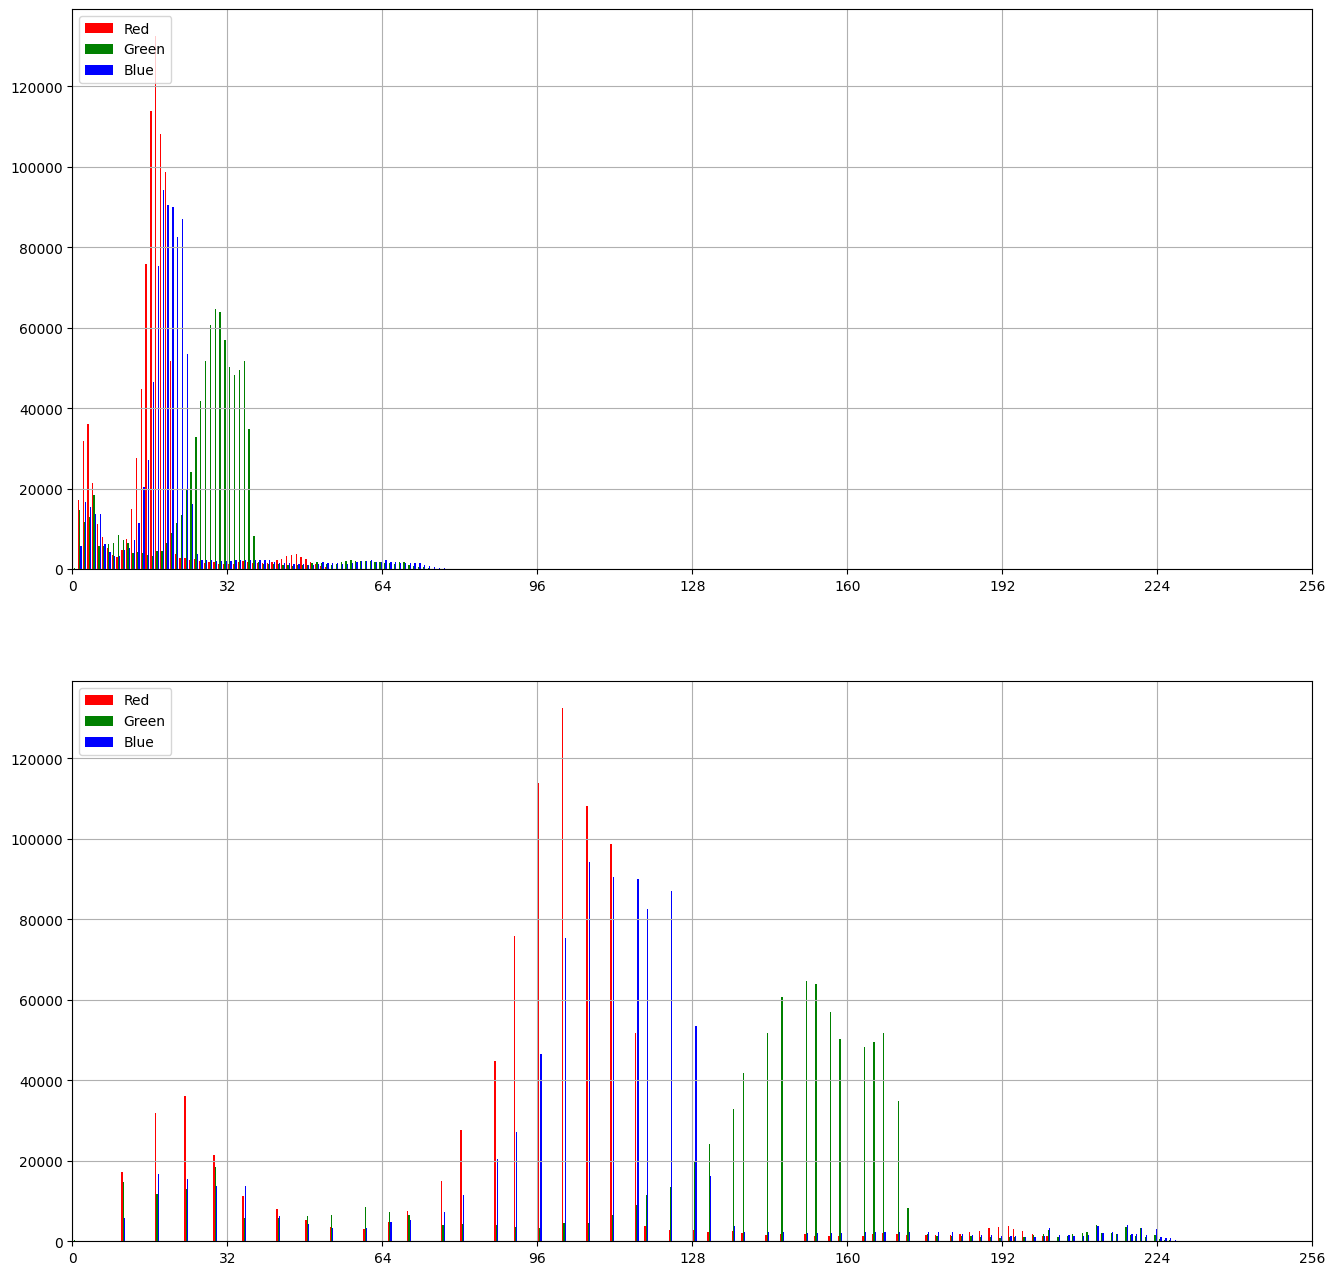

In [16]:
plt.figure(figsize=(16, 16))
img_YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

r = img[:, :, 2].flatten()
g = img[:, :, 1].flatten()
b = img[:, :, 0].flatten()

bins_range = range(0, 256, 1)       # bins は [0,256)という指定になる（https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html）
xtics_range = range(0, 256 + 1, 32) # 目盛りを256まで表示させたいので 256 + 1 に設定しているだけ

plt.figure(figsize=(16, 16))

# (R,G,B)
plt.subplot(211)
plt.hist((r, g, b), bins=bins_range, color=['r', 'g', 'b'], label=['Red', 'Green', 'Blue'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)



r = corrected_img[:, :, 2].flatten()
g = corrected_img[:, :, 1].flatten()
b = corrected_img[:, :, 0].flatten()
# (R,G,B)
plt.subplot(212)
plt.hist((r, g, b), bins=bins_range, color=['r', 'g', 'b'], label=['Red', 'Green', 'Blue'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)

plt.show()

### HSV空間でのヒストグラム

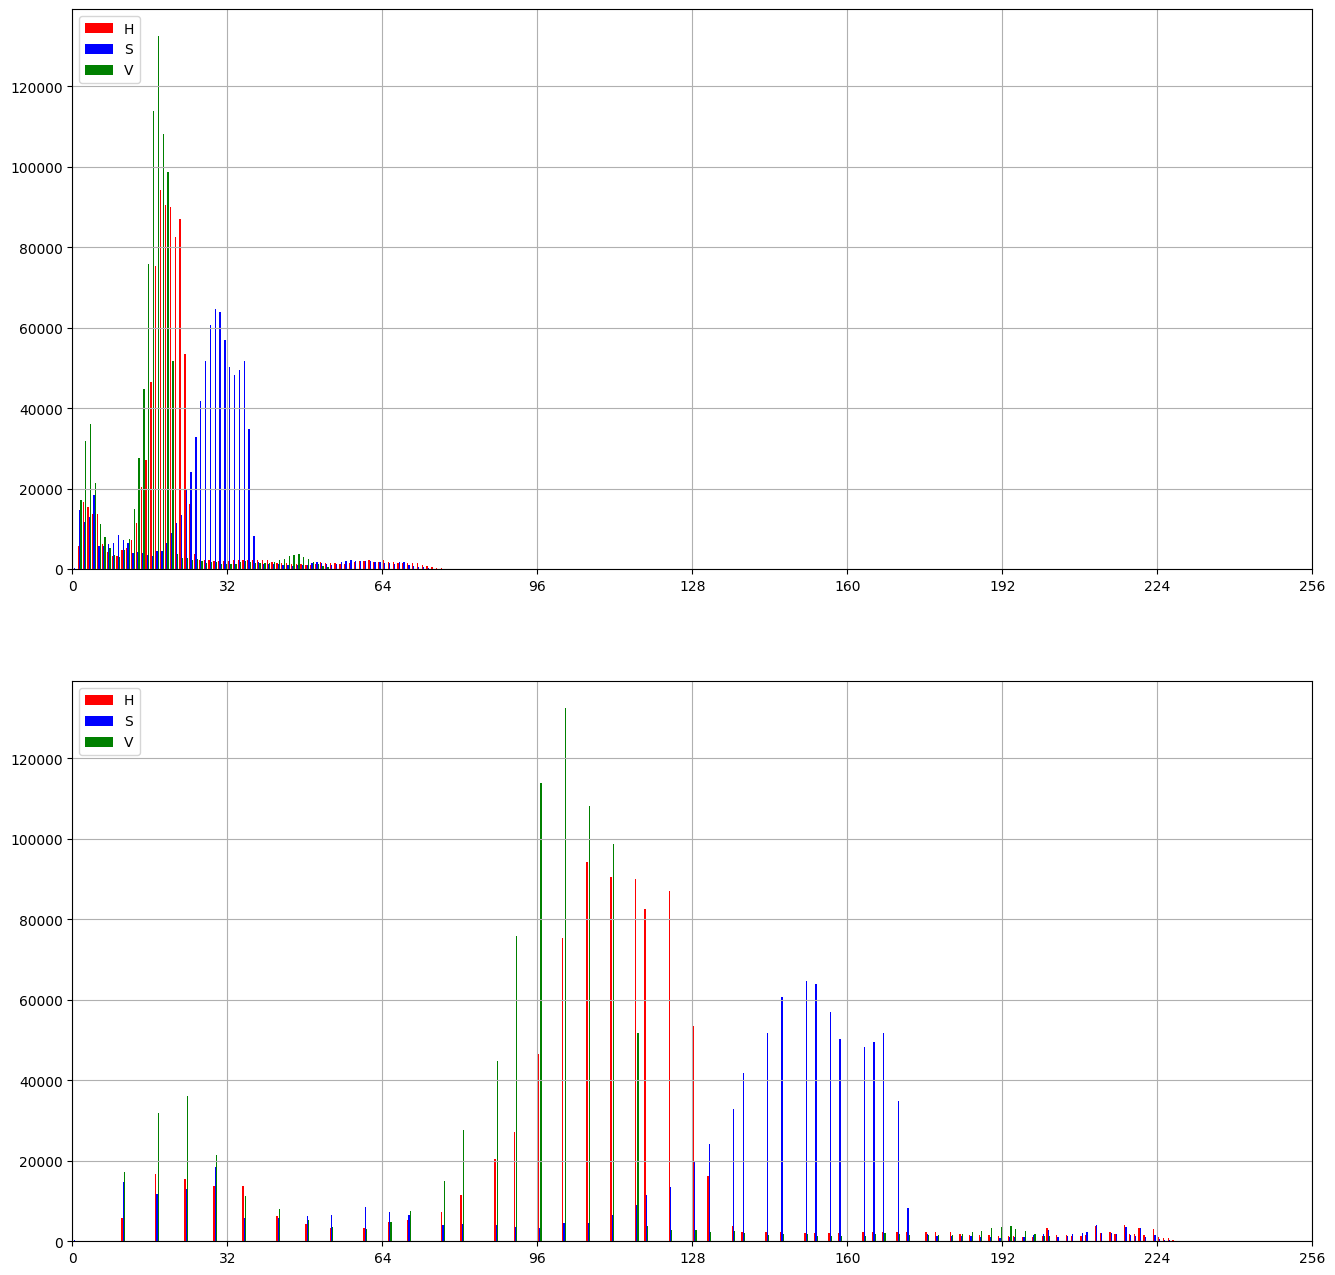

In [37]:
plt.figure(figsize=(16, 16))

hue = img[:, :, 0].flatten()
saturation = img[:, :, 1].flatten()
value = img[:, :, 2].flatten()


plt.subplot(211)
plt.hist((hue, saturation, value), bins=bins_range, color=['r', 'b', 'g'], label=['H', 'S', 'V'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)


hue = corrected_img[:, :, 0].flatten()
saturation = corrected_img[:, :, 1].flatten()
value = corrected_img[:, :, 2].flatten()


plt.subplot(212)
plt.hist((hue, saturation, value), bins=bins_range, color=['r', 'b', 'g'], label=['H', 'S', 'V'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)


plt.show()

### 結果と考察

#### 実験：
原画像における暗く・色彩が不明瞭という問題に対処するため、
ガンマ補正処理・コントラスト処理を行った。
ガンマ補正処理では、全体の明るさを上げることが出来たが、色彩が薄くなるため、明瞭に見せることを目的としてコントラスト補正処理を施した。

#### 結果：
画像の統計量のヒストグラムより、
処理前はRGBの諧調のほとんどが40以内に収まっていたのに対し、処理後は0～224の範囲まで広がっている。
また、HSVでは、S(彩度)・V(明度)ともに40に収まっていた処理前に比べ、処理後では170程度にまで広がっている。
これらのことから、原画像における諸問題が解決したと分かる。

---
### 3）画質の調整（例：鮮鋭化，ノイズ除去など）
#### 本処理の狙い
  * 本処理は色変換を行った後の画像について◎◎することを目的としている．
  * ここでは，？？という特徴を持った★★処理を適用する．

#### 結果と考察
  * 結果と考察を行う

## ------------------------------------------------------------------
## 課題 1-2)「パノラマ画像合成」
    
### 課題の目的

* ここまでの講義で扱ってきた画像処理の理論を理解しているかの確認
* ここまでの講義で扱ってきたサンプルコードを理解し，必要な関数を用いて上記理論を実装できるかの確認

### 課題
第7回目の講義で扱ったパノラマ画像合成手法について

  1. 講義では2視点のみを扱ったが，この手法を3視点以上の任意の視点数で実行可能なように拡張して，その実行結果を示せ．ただし，用いる画像は自身で撮影すること．
  1. １．の複数視点に拡張したパノラマ画像の問題点を上げて解決せよ．ただし，少なくとも以下の2点の課題は解決すること
      * 共通部分と非共通部分で色の濃淡が生じている
      * 非表示領域の黒枠が大きく残ってしまっている

【注意事項】
* 本課題の目的は画像処理のアルゴリズム構築と，その処理の理論的な記述法の習得（訓練）であることを理解して取り組むこと．
* したがって，<font color="red" style="font-weight:bolder;">cv2.sticher 関数をはじめ，直接的なパノラマ画像合成の機能を提供しているライブラリ群の使用は認めない</font>．ただし，画像の入出力，対応点検出や幾何学的変換に関してはOpenCVの関数を用いてよい


---
##  課題 1-3）解答用紙

以降，セルは適宜増やして用いること．

In [5]:
data_dirname = "data"
resized_ratio = 1
def prepare(filepath, ratio):
    image = MyImage(filepath)

    # リサイズ処理
    org_size = np.array(image.img.shape[:2]) # （縦，横）のみ取得
    out_size = (org_size * ratio).astype(int)
    _ = image.resize(out_size)
    image.img_info()
    return image

In [26]:
## キーポイントの画像座標をチェックする関数
def check_keypoint_coords(kp, top, left, bottom, right, margin=0):
    u = kp.pt[0]
    v = kp.pt[1]
    return (top + margin < v) and (left + margin < u) and (v < bottom - margin) and (u < right - margin) 

### 左側のマッチング

Num of correspondences (filtered by image coordinates): 36655


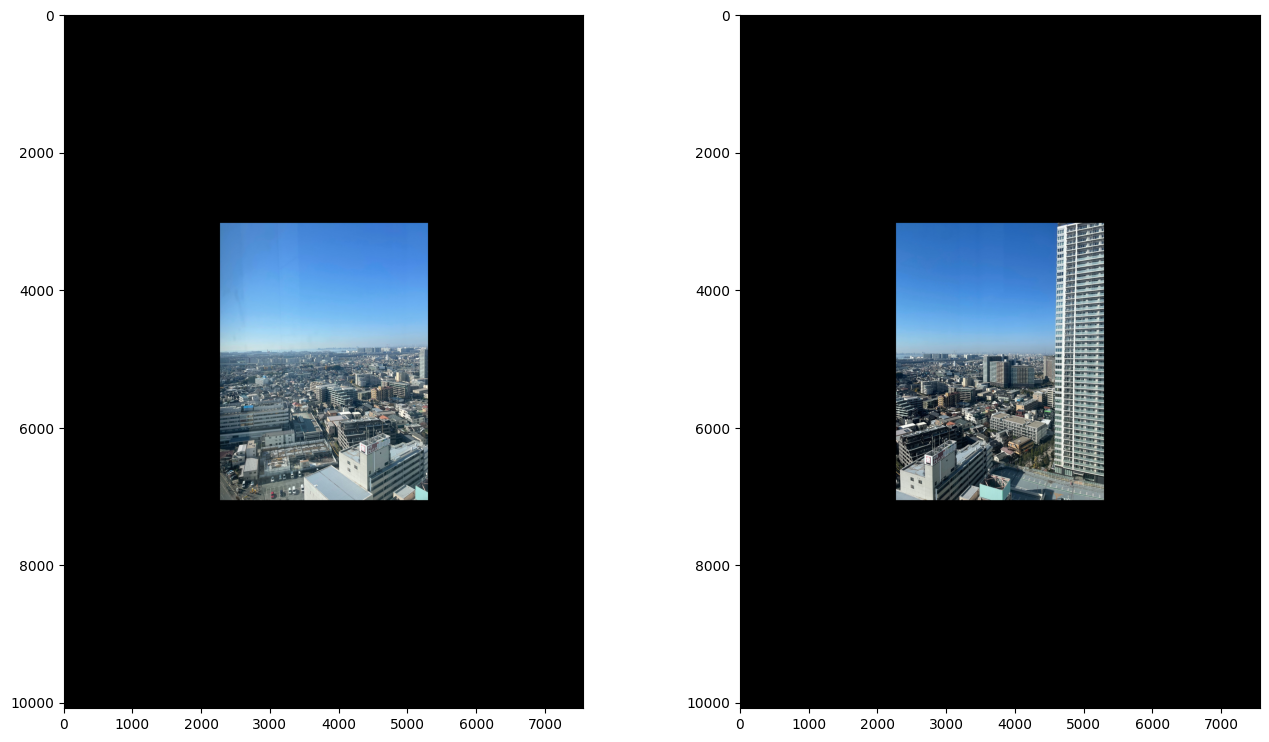

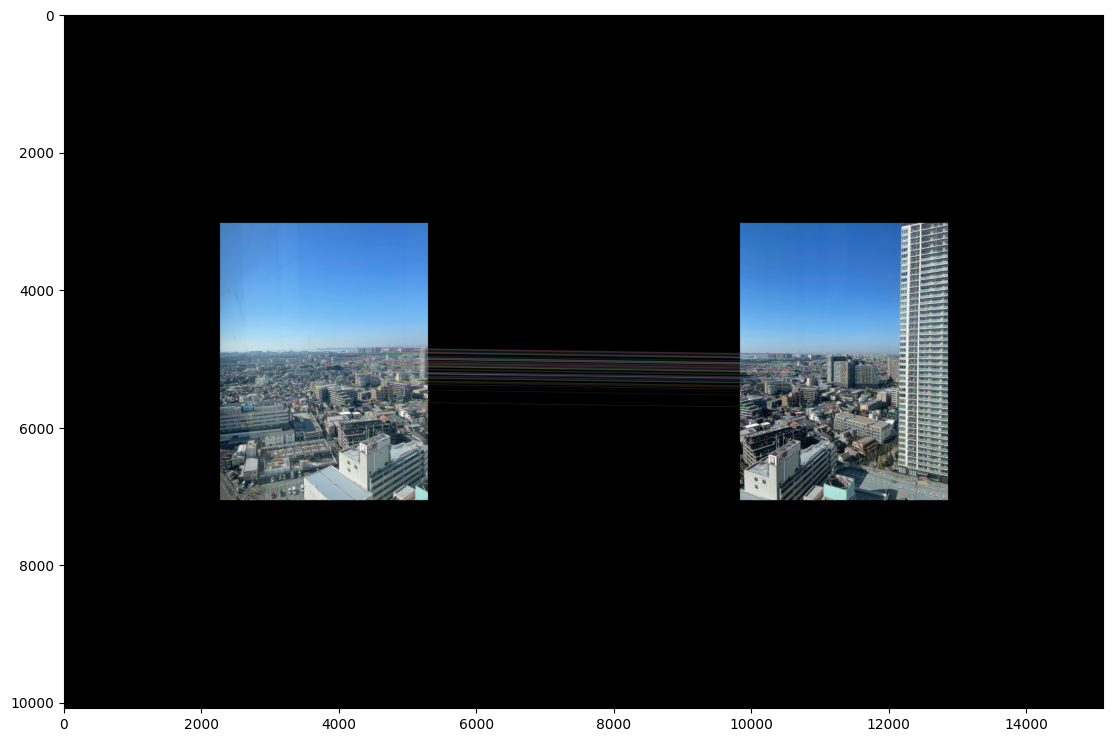

In [11]:
#===========================================================
# パノラマ用画像の準備
#===========================================================
# 左右の画像をセット
filepath = os.path.join('./', data_dirname, "IMG_4250.jpg").replace('/', os.sep)
l_img = prepare(filepath, resized_ratio)

filepath = os.path.join('./', data_dirname, "IMG_4251.jpg").replace('/', os.sep)
r_img = prepare(filepath, resized_ratio)

# 使用する画像のサイズは同じと仮定
l_h, l_w, l_ch = l_img.img.shape
r_h, r_w, r_ch = r_img.img.shape

if l_h!=r_h or l_w!=r_w or l_ch!=r_ch:
    print("----------------------------------------------")
    print("##### both images do not have equal size #####")
    print("----------------------------------------------")
else:
    
    # 画像のサイズ，チャネル数
    h = l_h
    w = l_w
    ch = l_ch
    
    #===========================================================
    # 表示用の余白あり画像の作成
    #===========================================================
    
    #------------------------------
    # 縦横何倍の画像を作るかの倍率
    #------------------------------
    multiple = 2.5
    #------------------------------

    margin_h = int((multiple - 1)*0.5*h)
    margin_w = int((multiple - 1)*0.5*w)

    left   = margin_w
    right  = margin_w + w
    top    = margin_h
    bottom = margin_h + h

    expanded_h, expanded_w = int(h*multiple), int(w*multiple)

    expanded_l_img = np.zeros((expanded_h, expanded_w, ch), dtype=np.uint8)
    expanded_r_img = np.zeros((expanded_h, expanded_w, ch), dtype=np.uint8)
    expanded_l_img[top:bottom, left:right, :] = l_img.img
    expanded_r_img[top:bottom, left:right, :] = r_img.img
    
    # 画像処理用に色空間を変換
    expanded_l_img_bgr = cv2.cvtColor(expanded_l_img, cv2.COLOR_BGR2RGB)
    expanded_r_img_bgr = cv2.cvtColor(expanded_r_img, cv2.COLOR_BGR2RGB)
    expanded_l_img_gray = cv2.cvtColor(expanded_l_img, cv2.COLOR_RGB2GRAY)
    expanded_r_img_gray = cv2.cvtColor(expanded_r_img, cv2.COLOR_RGB2GRAY)
    
    #===========================================================

    #----------------------------------------
    # 画像のマッチング処理
    #----------------------------------------
    # AKAZE 特徴量を求める
    detector = cv2.AKAZE_create()
    l_kp, l_des = detector.detectAndCompute(expanded_l_img_gray, None)
    r_kp, r_des = detector.detectAndCompute(expanded_r_img_gray, None)

    # 比較器作成
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # 画像への特徴点の書き込み
    matches = bf.match(l_des, r_des)
    matches = sorted(matches, key = lambda x:x.distance)

    # 【参考】画枠付近の特徴点を消す
    margin = 50
    matches = [match for match in matches \
               if check_keypoint_coords(l_kp[match.queryIdx], top, left, bottom, right, margin) \
               and check_keypoint_coords(r_kp[match.trainIdx], top, left, bottom, right, margin)]        
    num_correpondences = len(matches)
    print("Num of correspondences (filtered by image coordinates): {}".format(num_correpondences))

    # とりあえず上位100個を残す
    filtered_matches = matches[:100]
    
    height = expanded_h
    width  = expanded_w * 2

    out = np.zeros((height, width, ch), np.uint8)
    cv2.drawMatches(expanded_l_img_bgr, l_kp, expanded_r_img_bgr, r_kp, filtered_matches, out, flags=0)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(expanded_l_img)
    plt.subplot(122)
    plt.imshow(expanded_r_img)

    # 対応点をプロットした画像を表示用に変換
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(111)
    plt.imshow(out)

    plt.show()

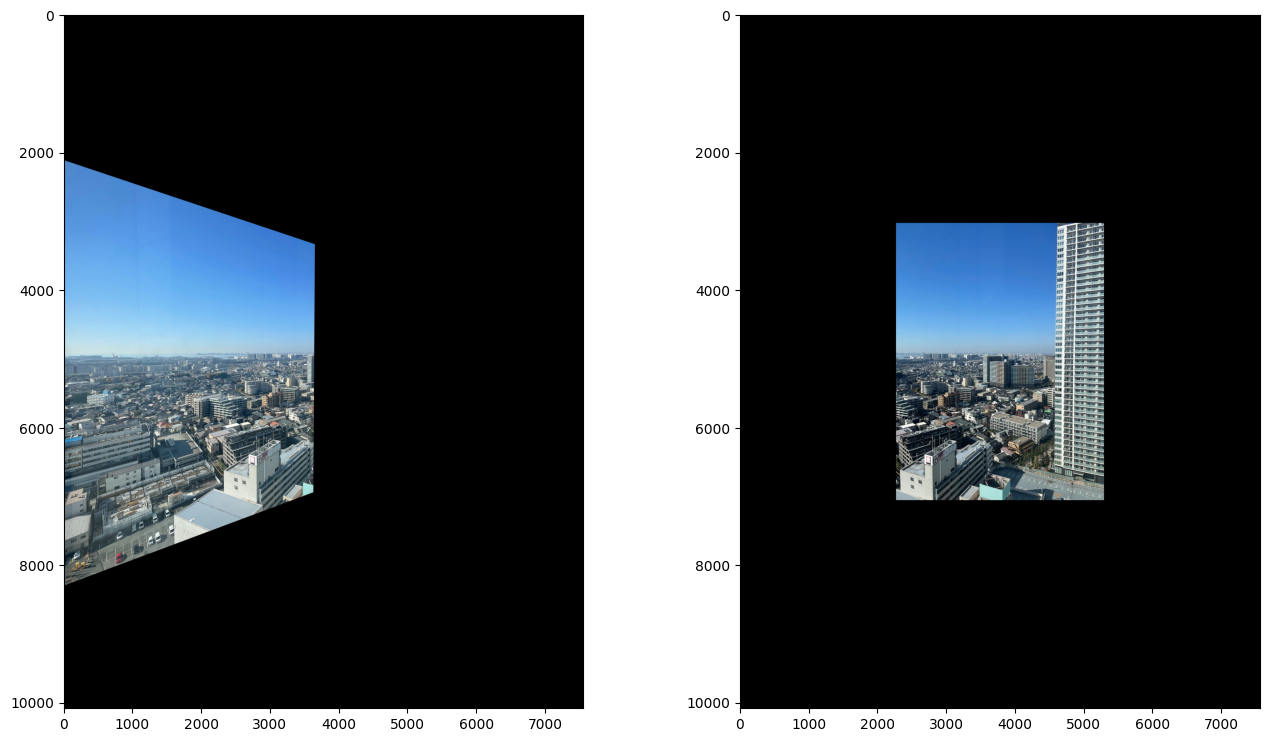

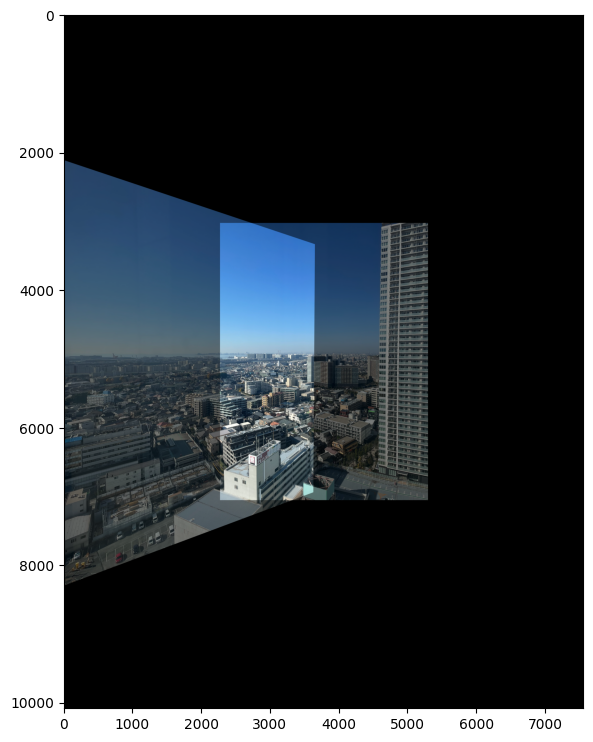

In [12]:
# 良いマッチングをしている点のみ残す（Lowe's ratio test）
good_match_rate = 0.7
good = matches[:int(len(matches) * good_match_rate)]
src_l_pts = np.float32([ l_kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_r_pts = np.float32([ r_kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# （左→右）のホモグラフィ行列の算出
H, mask = cv2.findHomography(src_l_pts, dst_r_pts, cv2.RANSAC, 5.0)

# 左画像のホモグラフィ（射影変換）を求める
warped_l_img = cv2.warpPerspective(expanded_l_img, H, (expanded_w, expanded_h))

fig = plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(warped_l_img)
plt.subplot(122)
plt.imshow(expanded_r_img)

# 画像の合成
panoramal_img = cv2.addWeighted(warped_l_img, 0.5, expanded_r_img, 0.5, 0)
fig = plt.figure(figsize=(16,9))
plt.imshow(panoramal_img)

plt.show()

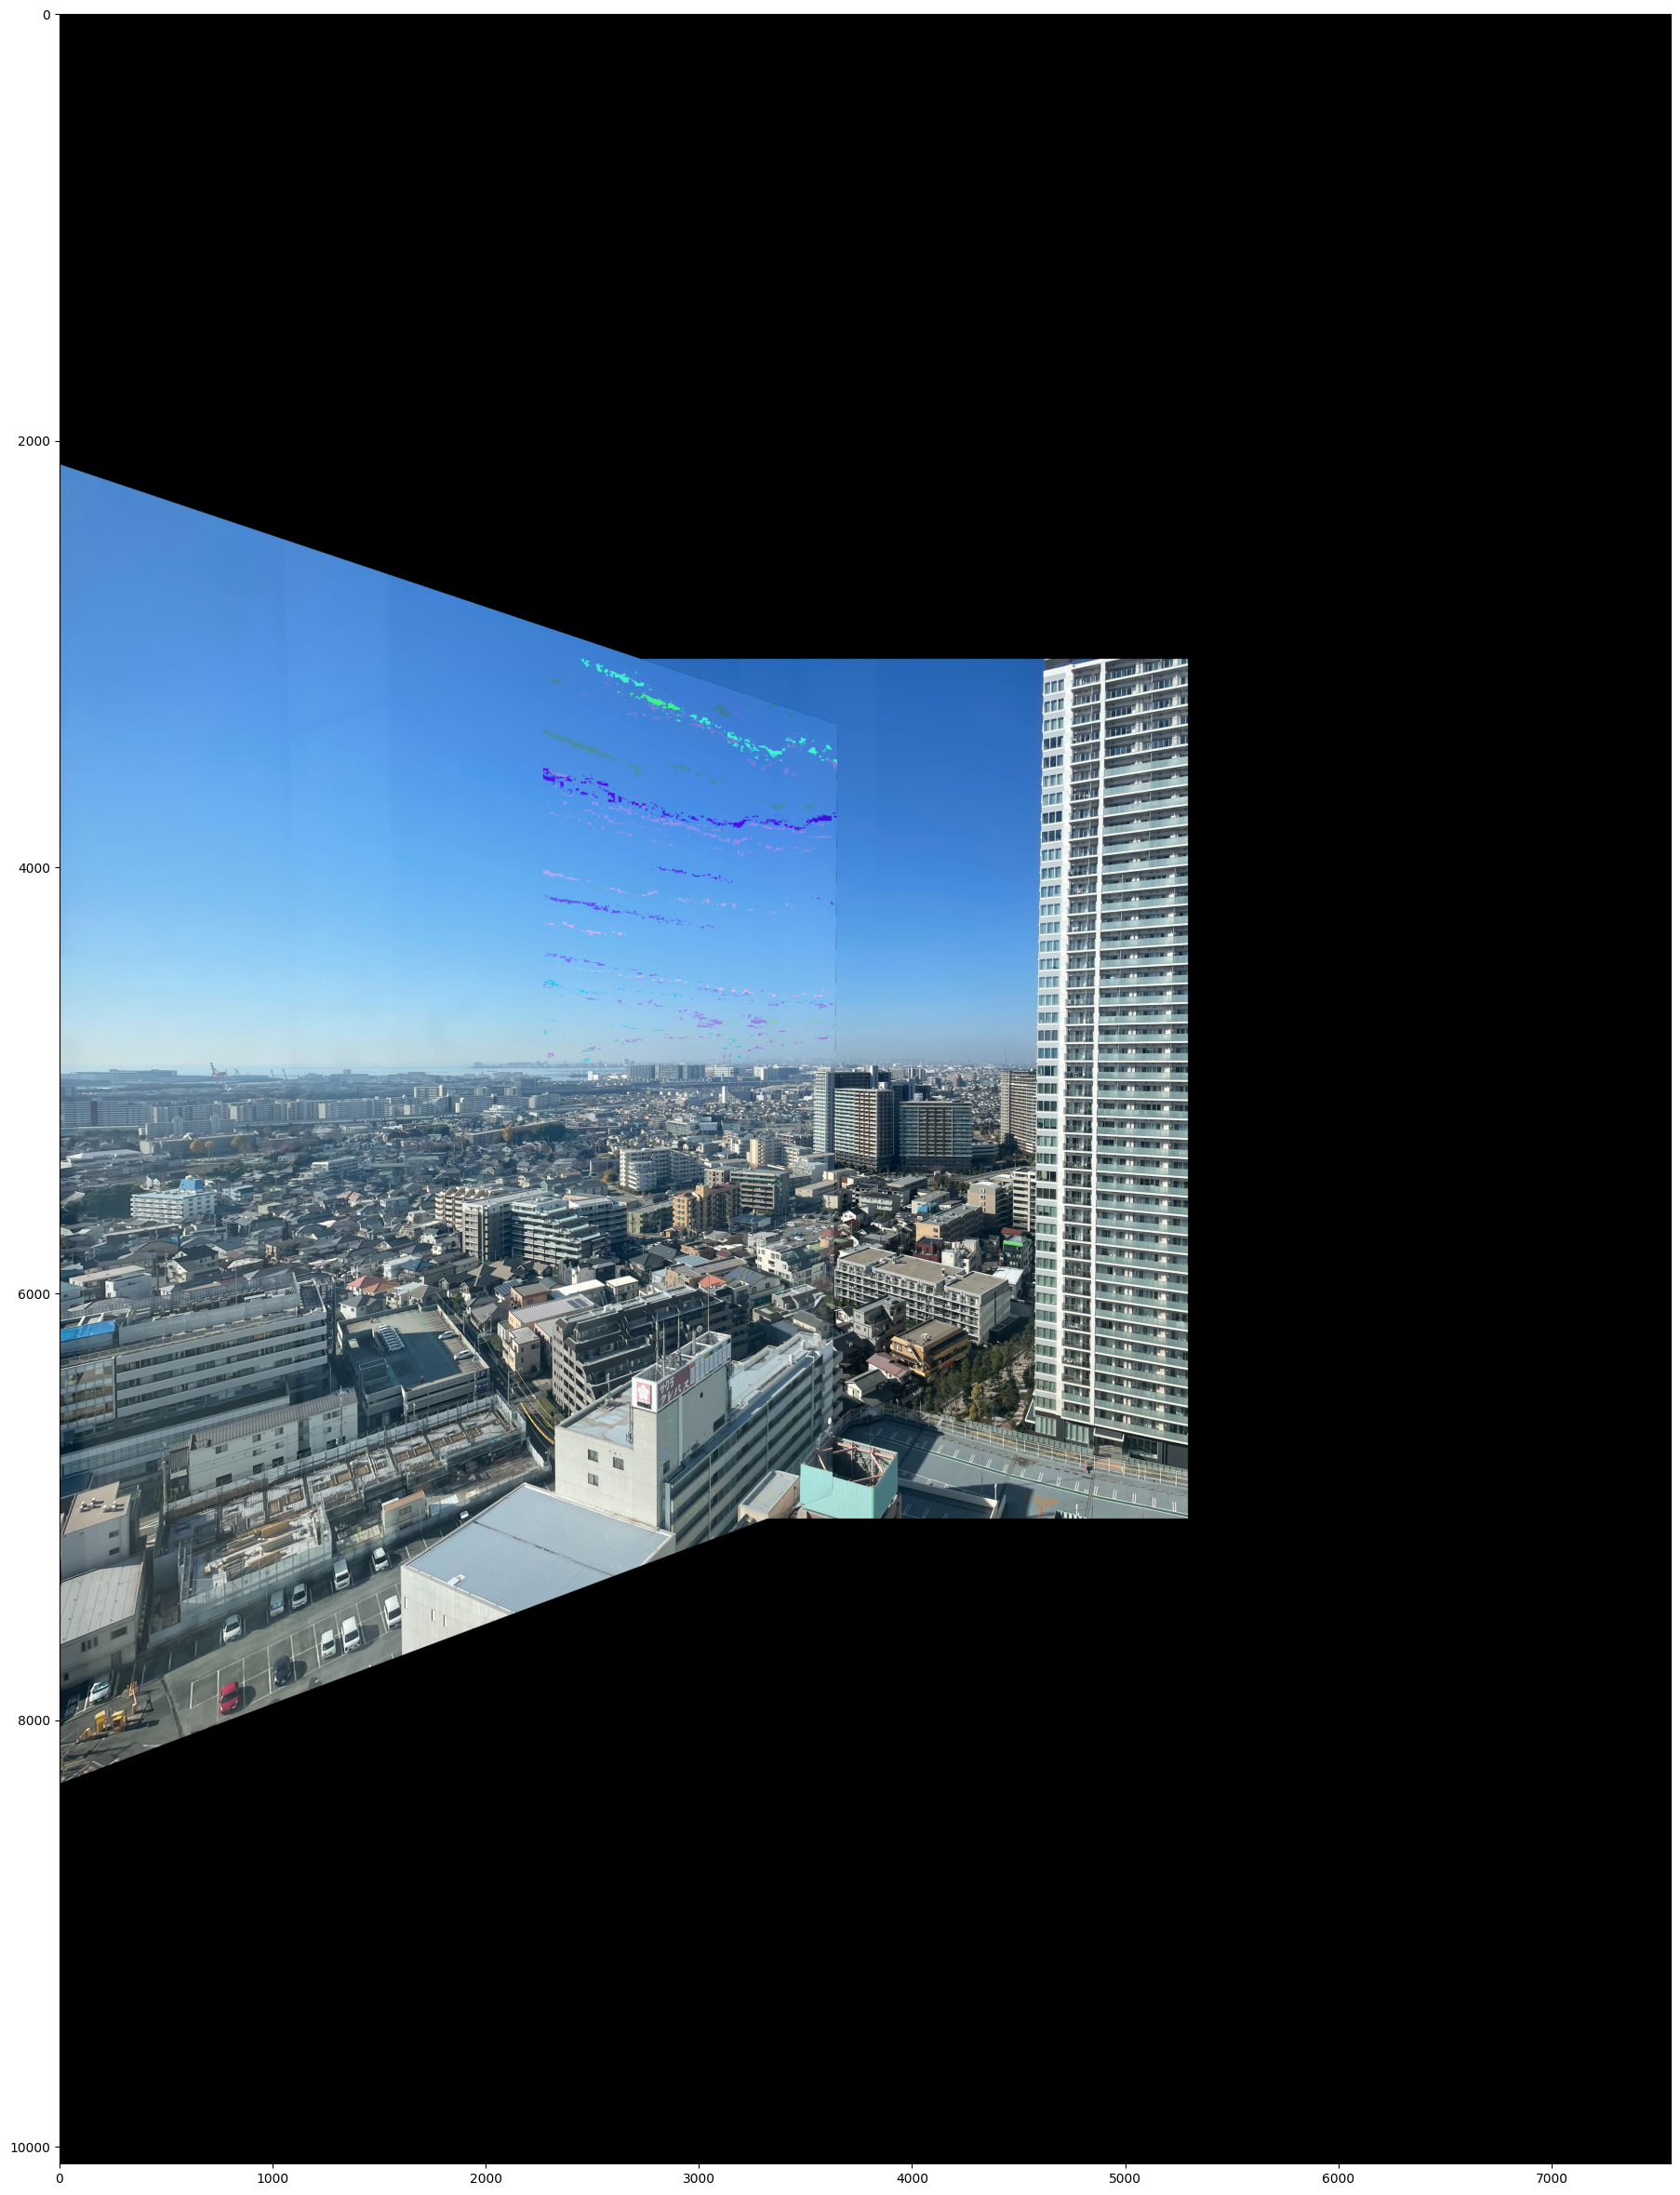

In [13]:
# 差分画像の計算
difference_data = expanded_r_img * warped_l_img

# 差が0より大きい部分を1に変換
difference_mask = (difference_data > 0).astype(np.uint8)

# data1に差分を適用
data4 = expanded_r_img + warped_l_img - (expanded_r_img * difference_mask)

# 表示
fig = plt.figure(figsize=(30, 30))
plt.imshow(data4)
plt.show()


In [14]:
# パノラマ画像を保存するパス
output_path = "data/panoramal.jpg"

# 画像を保存
cv2.imwrite(output_path, cv2.cvtColor(data4, cv2.COLOR_BGR2RGB))

# 保存が成功したかどうかのメッセージを表示
print(f"Panorama image saved to {output_path}")


Panorama image saved to data/panoramal.jpg


### 右側のマッチング

Num of correspondences (filtered by image coordinates): 56767


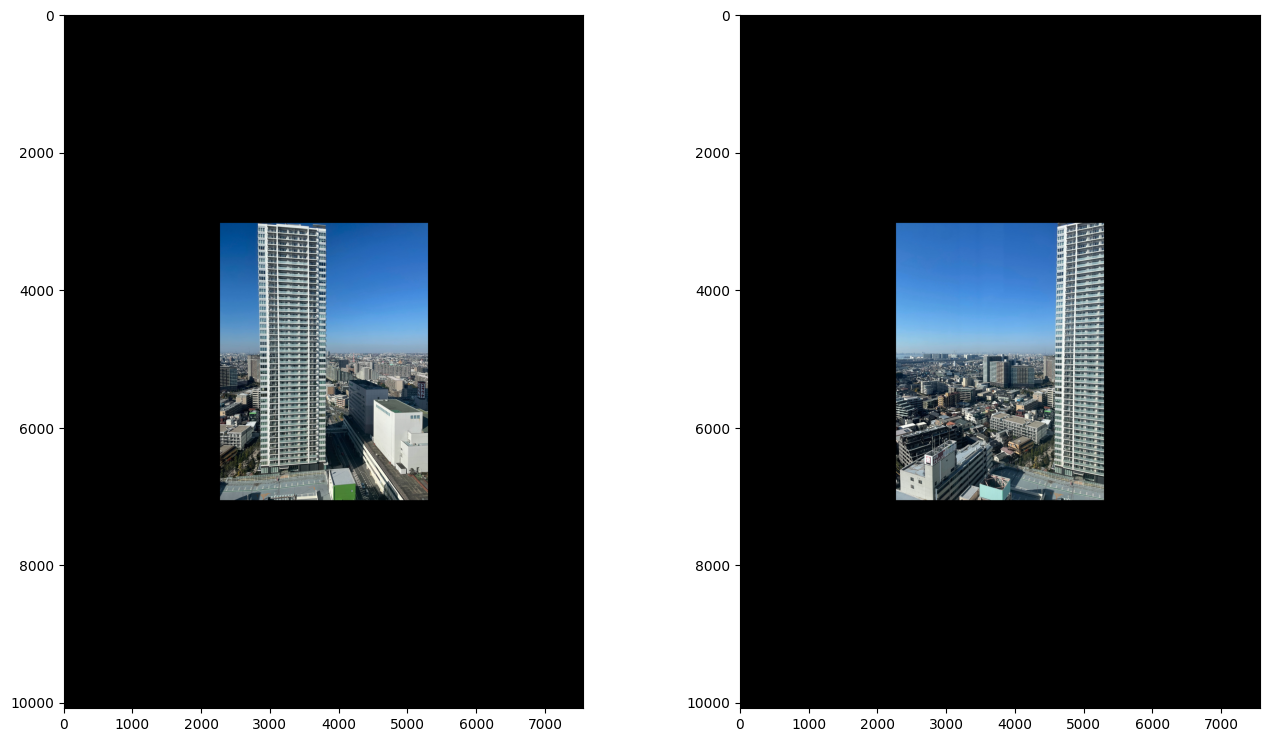

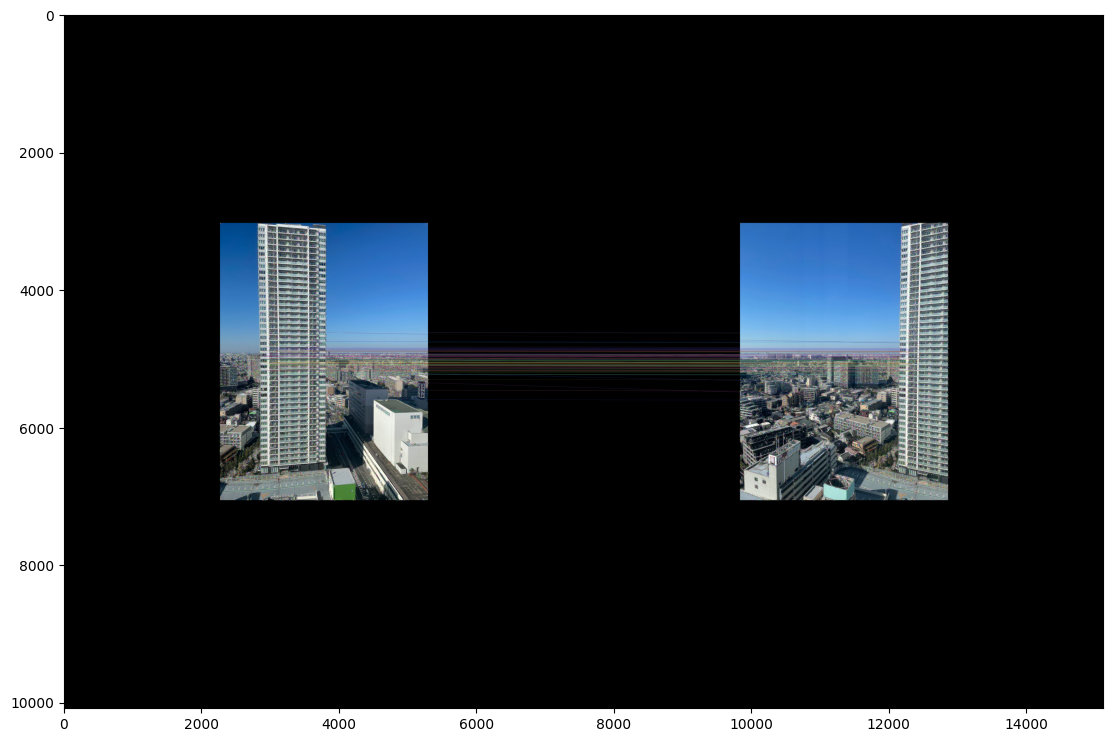

In [15]:
#===========================================================
# パノラマ用画像の準備
#===========================================================
# 左右の画像をセット
filepath = os.path.join('./', data_dirname, "IMG_4252.jpg").replace('/', os.sep)
l_img = prepare(filepath, resized_ratio)

filepath = os.path.join('./', data_dirname, "IMG_4251.jpg").replace('/', os.sep)
r_img = prepare(filepath, resized_ratio)

# 使用する画像のサイズは同じと仮定
l_h, l_w, l_ch = l_img.img.shape
r_h, r_w, r_ch = r_img.img.shape

if l_h!=r_h or l_w!=r_w or l_ch!=r_ch:
    print("----------------------------------------------")
    print("##### both images do not have equal size #####")
    print("----------------------------------------------")
else:
    
    # 画像のサイズ，チャネル数
    h = l_h
    w = l_w
    ch = l_ch
    
    #===========================================================
    # 表示用の余白あり画像の作成
    #===========================================================
    
    #------------------------------
    # 縦横何倍の画像を作るかの倍率
    #------------------------------
    multiple = 2.5
    #------------------------------

    margin_h = int((multiple - 1)*0.5*h)
    margin_w = int((multiple - 1)*0.5*w)

    left   = margin_w
    right  = margin_w + w
    top    = margin_h
    bottom = margin_h + h

    expanded_h, expanded_w = int(h*multiple), int(w*multiple)

    expanded_l_img = np.zeros((expanded_h, expanded_w, ch), dtype=np.uint8)
    expanded_r_img = np.zeros((expanded_h, expanded_w, ch), dtype=np.uint8)
    expanded_l_img[top:bottom, left:right, :] = l_img.img
    expanded_r_img[top:bottom, left:right, :] = r_img.img
    
    # 画像処理用に色空間を変換
    expanded_l_img_bgr = cv2.cvtColor(expanded_l_img, cv2.COLOR_BGR2RGB)
    expanded_r_img_bgr = cv2.cvtColor(expanded_r_img, cv2.COLOR_BGR2RGB)
    expanded_l_img_gray = cv2.cvtColor(expanded_l_img, cv2.COLOR_RGB2GRAY)
    expanded_r_img_gray = cv2.cvtColor(expanded_r_img, cv2.COLOR_RGB2GRAY)
    
    #===========================================================

    #----------------------------------------
    # 画像のマッチング処理
    #----------------------------------------
    # AKAZE 特徴量を求める
    detector = cv2.AKAZE_create()
    l_kp, l_des = detector.detectAndCompute(expanded_l_img_gray, None)
    r_kp, r_des = detector.detectAndCompute(expanded_r_img_gray, None)

    # 比較器作成
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # 画像への特徴点の書き込み
    matches = bf.match(l_des, r_des)
    matches = sorted(matches, key = lambda x:x.distance)

    # 【参考】画枠付近の特徴点を消す
    margin = 50
    matches = [match for match in matches \
               if check_keypoint_coords(l_kp[match.queryIdx], top, left, bottom, right, margin) \
               and check_keypoint_coords(r_kp[match.trainIdx], top, left, bottom, right, margin)]        
    num_correpondences = len(matches)
    print("Num of correspondences (filtered by image coordinates): {}".format(num_correpondences))

    # とりあえず上位100個を残す
    filtered_matches = matches[:100]
    
    height = expanded_h
    width  = expanded_w * 2

    out = np.zeros((height, width, ch), np.uint8)
    cv2.drawMatches(expanded_l_img_bgr, l_kp, expanded_r_img_bgr, r_kp, filtered_matches, out, flags=0)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(expanded_l_img)
    plt.subplot(122)
    plt.imshow(expanded_r_img)

    # 対応点をプロットした画像を表示用に変換
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(111)
    plt.imshow(out)

    plt.show()

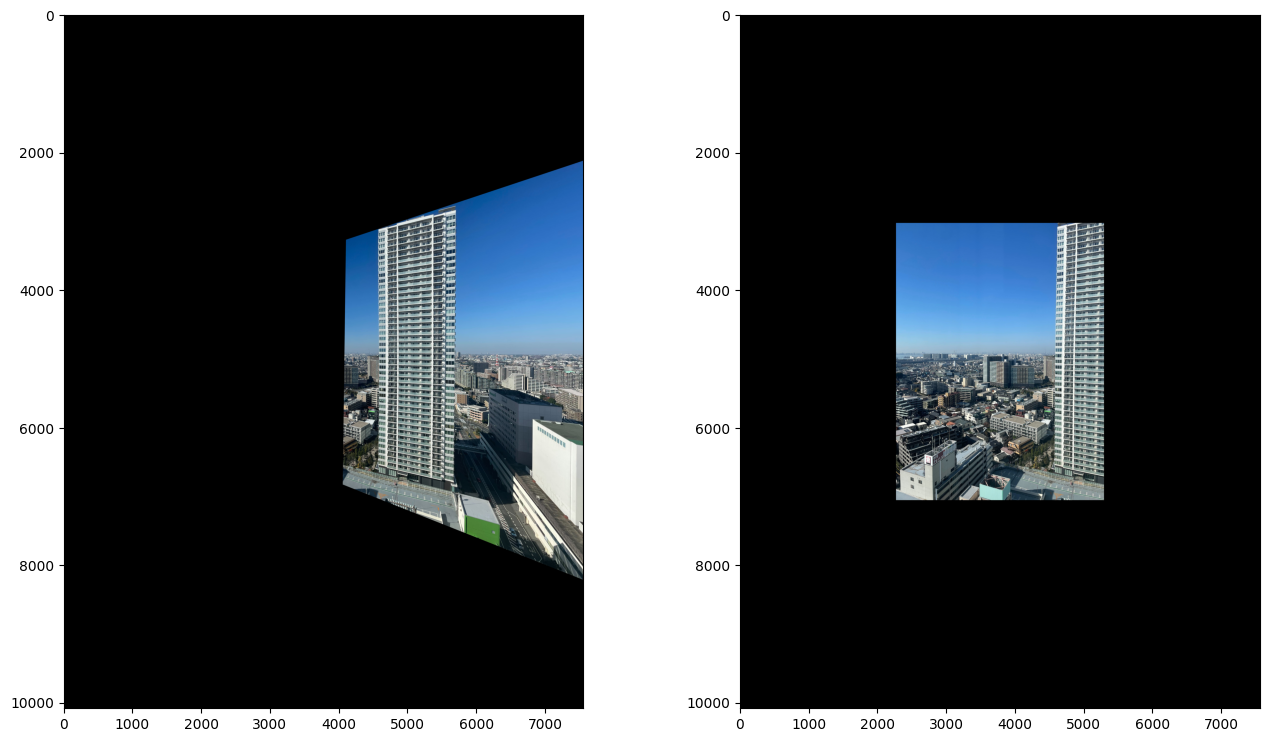

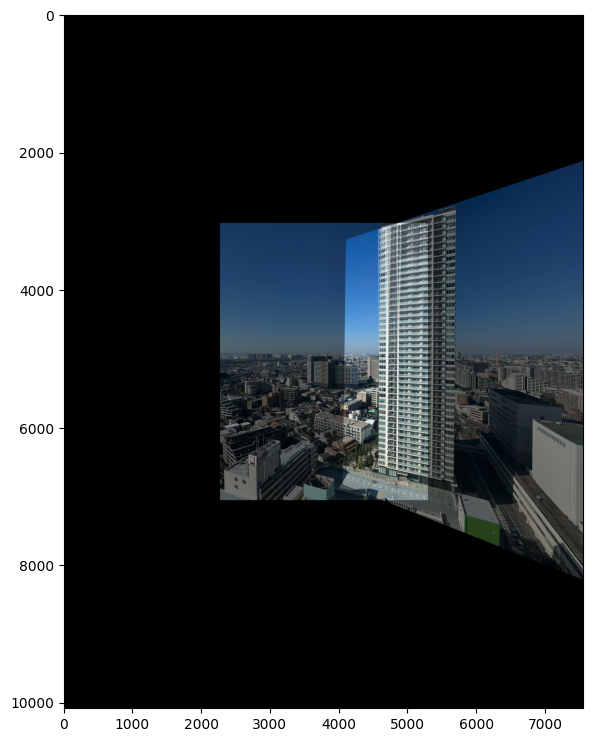

In [16]:
# 良いマッチングをしている点のみ残す（Lowe's ratio test）
good_match_rate = 0.7
good = matches[:int(len(matches) * good_match_rate)]
src_l_pts = np.float32([ l_kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_r_pts = np.float32([ r_kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# （左→右）のホモグラフィ行列の算出
H, mask = cv2.findHomography(src_l_pts, dst_r_pts, cv2.RANSAC, 5.0)

# 左画像のホモグラフィ（射影変換）を求める
warped_l_img = cv2.warpPerspective(expanded_l_img, H, (expanded_w, expanded_h))

fig = plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(warped_l_img)
plt.subplot(122)
plt.imshow(expanded_r_img)

# 画像の合成
panoramar_img = cv2.addWeighted(warped_l_img, 0.5, expanded_r_img, 0.5, 0)
fig = plt.figure(figsize=(16,9))
plt.imshow(panoramar_img)

plt.show()

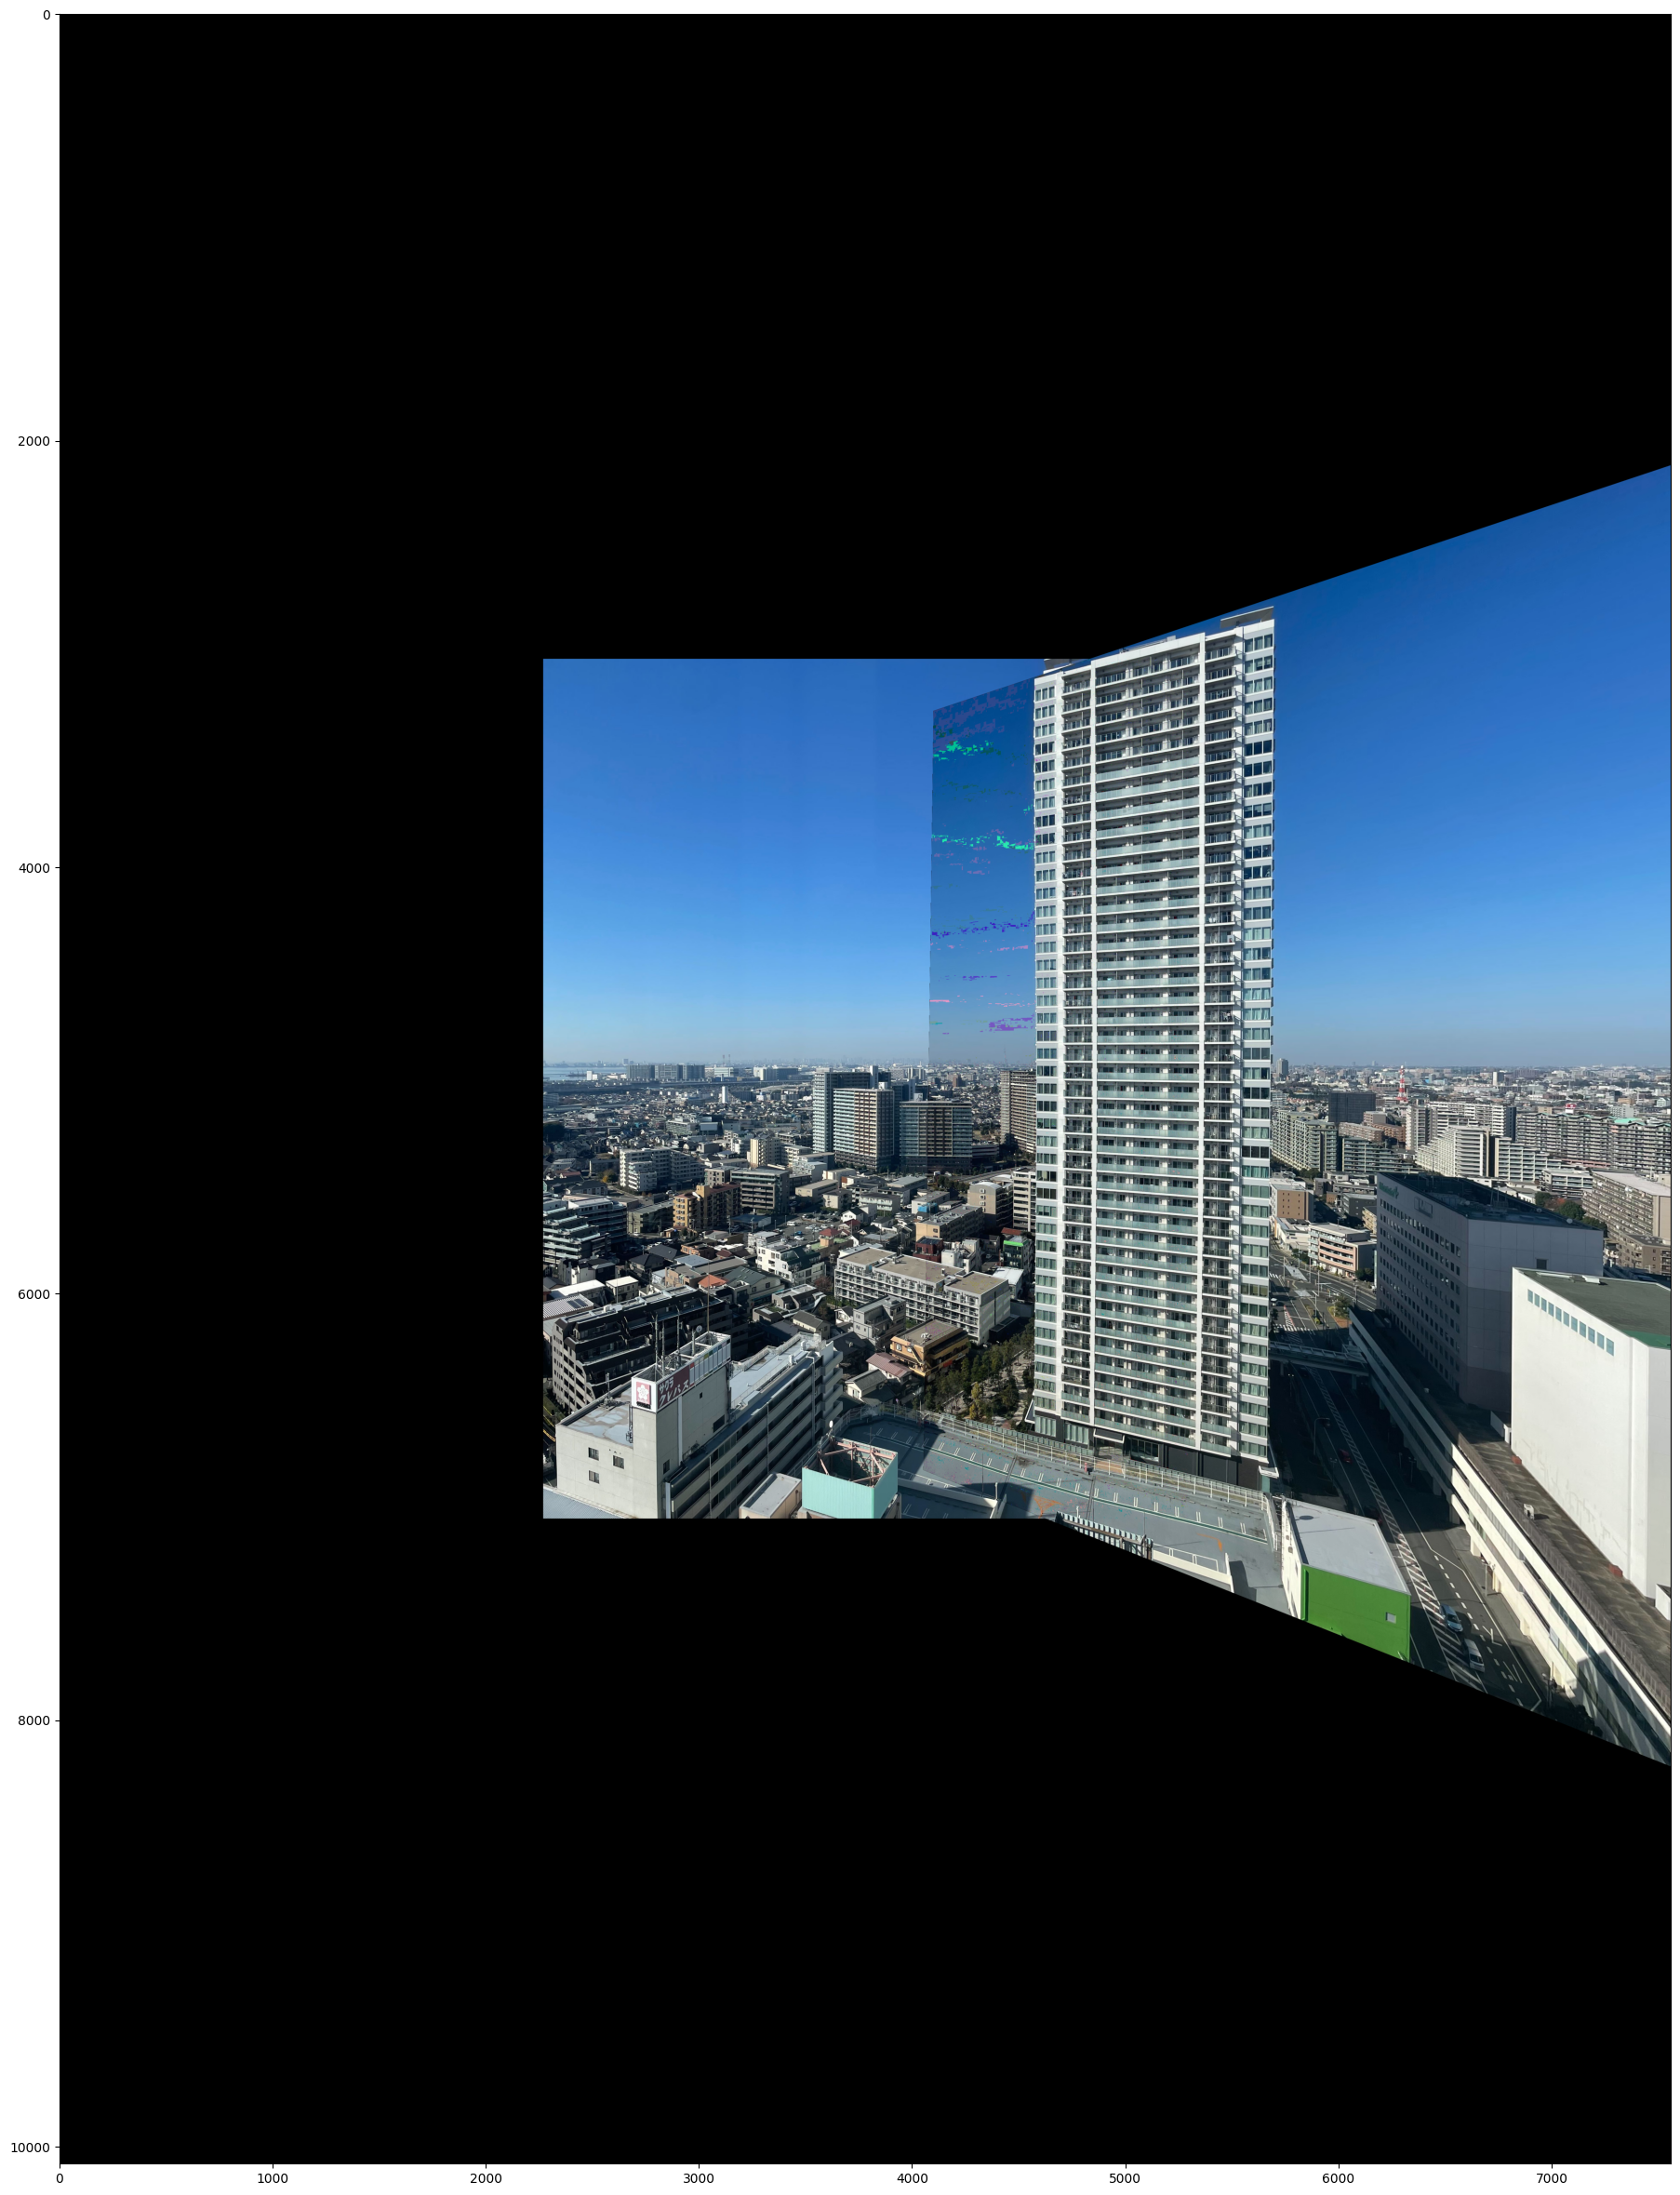

In [17]:
# 差分画像の計算
difference_data = expanded_r_img * warped_l_img

# 差が0より大きい部分を1に変換
difference_mask = (difference_data > 0).astype(np.uint8)

# data1に差分を適用
data5 = expanded_r_img + warped_l_img - (expanded_r_img * difference_mask)

# 表示
fig = plt.figure(figsize=(30, 30))
plt.imshow(data5)
plt.show()


In [18]:
# パノラマ画像を保存するパス
output_path = "data/panoramar.jpg"

# 画像を保存
cv2.imwrite(output_path, cv2.cvtColor(data5, cv2.COLOR_BGR2RGB))

# 保存が成功したかどうかのメッセージを表示
print(f"Panorama image saved to {output_path}")


Panorama image saved to data/panoramar.jpg


### 画像の保存・圧縮

In [55]:
# パノラマ画像を保存するパス
output_path = "data/panoramal.jpg"

# 画像を保存
cv2.imwrite(output_path, cv2.cvtColor(panoramal_img, cv2.COLOR_BGR2RGB))

# 保存が成功したかどうかのメッセージを表示
print(f"Panorama image saved to {output_path}")


Panorama image saved to data/panoramal.jpg


In [54]:
# パノラマ画像を保存するパス
output_path = "data/panoramar.jpg"

# 画像を保存
cv2.imwrite(output_path, cv2.cvtColor(panoramar_img, cv2.COLOR_BGR2RGB))

# 保存が成功したかどうかのメッセージを表示
print(f"Panorama image saved to {output_path}")


Panorama image saved to data/panoramar.jpg


In [67]:
output_path = "data/smaller_panoramal_img.jpg"
# 画像をリサイズする
smaller_panoramal_img = cv2.resize(panoramal_img, (width, height), interpolation=cv2.INTER_AREA)

# パノラマ画像を保存
cv2.imwrite(output_path, cv2.cvtColor(smaller_panoramal_img, cv2.COLOR_BGR2RGB))


True

In [69]:
output_path = "data/smaller_panoramar_img.jpg"
# 画像をリサイズする
smaller_panoramar_img = cv2.resize(panoramar_img, (width, height), interpolation=cv2.INTER_AREA)

# パノラマ画像を保存
cv2.imwrite(output_path, cv2.cvtColor(smaller_panoramar_img, cv2.COLOR_BGR2RGB))


True

### 合成

In [22]:
#===========================================================
# パノラマ用画像の準備
#===========================================================
# 左右の画像をセット
filepath = os.path.join('./', data_dirname, "panoramal.jpg").replace('/', os.sep)
l_img = prepare(filepath, resized_ratio)

filepath = os.path.join('./', data_dirname, "panoramar.jpg").replace('/', os.sep)
r_img = prepare(filepath, resized_ratio)

# 使用する画像のサイズは同じと仮定
l_h, l_w, l_ch = l_img.img.shape
r_h, r_w, r_ch = r_img.img.shape

if l_h!=r_h or l_w!=r_w or l_ch!=r_ch:
    print("----------------------------------------------")
    print("##### both images do not have equal size #####")
    print("----------------------------------------------")
else:
    
    # 画像のサイズ，チャネル数
    h = l_h
    w = l_w
    ch = l_ch
    
    #===========================================================
    # 表示用の余白あり画像の作成
    #===========================================================
    
    #------------------------------
    # 縦横何倍の画像を作るかの倍率
    #------------------------------
    multiple = 2.5
    #------------------------------

    margin_h = int((multiple - 1)*0.5*h)
    margin_w = int((multiple - 1)*0.5*w)

    left   = margin_w
    right  = margin_w + w
    top    = margin_h
    bottom = margin_h + h

    expanded_h, expanded_w = int(h*multiple), int(w*multiple)

    expanded_l_img = np.zeros((expanded_h, expanded_w, ch), dtype=np.uint8)
    expanded_r_img = np.zeros((expanded_h, expanded_w, ch), dtype=np.uint8)
    expanded_l_img[top:bottom, left:right, :] = l_img.img
    expanded_r_img[top:bottom, left:right, :] = r_img.img
    
    # 画像処理用に色空間を変換
    expanded_l_img_bgr = cv2.cvtColor(expanded_l_img, cv2.COLOR_BGR2RGB)
    expanded_r_img_bgr = cv2.cvtColor(expanded_r_img, cv2.COLOR_BGR2RGB)
    expanded_l_img_gray = cv2.cvtColor(expanded_l_img, cv2.COLOR_RGB2GRAY)
    expanded_r_img_gray = cv2.cvtColor(expanded_r_img, cv2.COLOR_RGB2GRAY)
    
    #===========================================================

    #----------------------------------------
    # 画像のマッチング処理
    #----------------------------------------
    # AKAZE 特徴量を求める
    detector = cv2.AKAZE_create()
    l_kp, l_des = detector.detectAndCompute(expanded_l_img_gray, None)
    r_kp, r_des = detector.detectAndCompute(expanded_r_img_gray, None)

    # 比較器作成
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)

    # 画像への特徴点の書き込み
    matches = bf.match(l_des, r_des)
    matches = sorted(matches, key = lambda x:x.distance)

    # 【参考】画枠付近の特徴点を消す
    margin = 50
    matches = [match for match in matches \
               if check_keypoint_coords(l_kp[match.queryIdx], top, left, bottom, right, margin) \
               and check_keypoint_coords(r_kp[match.trainIdx], top, left, bottom, right, margin)]        
    num_correpondences = len(matches)
    print("Num of correspondences (filtered by image coordinates): {}".format(num_correpondences))

    # とりあえず上位100個を残す
    filtered_matches = matches[:100]
    
    height = expanded_h
    width  = expanded_w * 2

    out = np.zeros((height, width, ch), np.uint8)
    cv2.drawMatches(expanded_l_img_bgr, l_kp, expanded_r_img_bgr, r_kp, filtered_matches, out, flags=0)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(expanded_l_img)
    plt.subplot(122)
    plt.imshow(expanded_r_img)

    # 対応点をプロットした画像を表示用に変換
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

    fig = plt.figure(figsize=(16,9))
    plt.subplot(111)
    plt.imshow(out)

    plt.show()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 1905120000 bytes in function 'cv::OutOfMemoryError'
